In [2]:
import os
import pandas as pd
import geopandas as gpd
import fiona
import numpy as np
import shapely as sp
from scipy import spatial
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt

italy_regions_path = '/mnt/data/shared/aws-data/public-data/boundaries-regions-2015/Com2015_WGS84_g/IT_com_WGS84.shp'
cdr_path = '/mnt/data/shared/unique_users_lat_lon_minus_outliers_no_commas.csv'
land_use_path = '/mnt/data/shared/aws-data/public-data/land-use/firenze-cropped-shapefiles/land_use_firenze_comune.shp'

cdr_separator = '\t'
cdr_encoding = 'utf-8'
cdr_decimal = '.'
crs = {'init': 'epsg:4326'}

italy_regions_shp = gpd.read_file(italy_regions_path).to_crs(epsg=4326)
firenze_shp = italy_regions_shp[italy_regions_shp["COMUNE"] == "Firenze"]
firenze_land_use_shp = gpd.read_file(land_use_path).to_crs(epsg=4326)

cdr_records = pd.read_csv(cdr_path, encoding=cdr_encoding, sep=cdr_separator, index_col=None, decimal=cdr_decimal)
geo_points = [sp.geometry.Point(xy) for xy in zip(cdr_records.lon, cdr_records.lat)]
cdr_geo = gpd.GeoDataFrame(cdr_records, crs=crs, geometry = geo_points)
cdr_geo = cdr_geo.to_crs(epsg=4326)

towers_in_firenze = cdr_geo[cdr_geo.within(firenze_shp.unary_union)]
tower_points = np.array(towers_in_firenze.geometry)
towers = [np.array([point.x, point.y]) for point in tower_points]

In [3]:
vor = Voronoi(towers)
lines = [
    sp.geometry.LineString(vor.vertices[line])
    for line in vor.ridge_vertices
    if -1 not in line
]

voronoi_polys = sp.ops.polygonize(lines)
voronoi_geo = gpd.GeoDataFrame(crs=crs, geometry=list(voronoi_polys)).to_crs(epsg=4326)
voronoi_geo_in_firenze = voronoi_geo[voronoi_geo.within(firenze_shp.unary_union)]

firenze_with_voronoi = gpd.sjoin(towers_in_firenze, voronoi_geo_in_firenze,  how="inner", op='within')
del firenze_with_voronoi['geometry']

voronoi_geo_in_firenze = voronoi_geo_in_firenze.merge(firenze_with_voronoi, left_index=True, right_on='index_right')
voronoi_geo_in_firenze = voronoi_geo_in_firenze.assign(count_area = lambda x: x.users / x.geometry.area)
voronoi_geo_in_firenze = voronoi_geo_in_firenze.assign(count_area_log = lambda x: np.log(x.users) / x.geometry.area)

#voronoi_geojson = sp.geometry.mapping(voronoi_polys)

# geo_points = [sp.geometry.Point(xy) for xy in zip(cdr_records.lon, cdr_records.lat)]
# cdr_geo = gpd.GeoDataFrame(cdr_records, crs=crs, geometry = geo_points)
# cdr_geo = cdr_geo.to_crs(epsg=4326)
### voronoi_geo_in_firenze = voronoi_geo['geometry'].intersection(firenze_shp.unary_union)

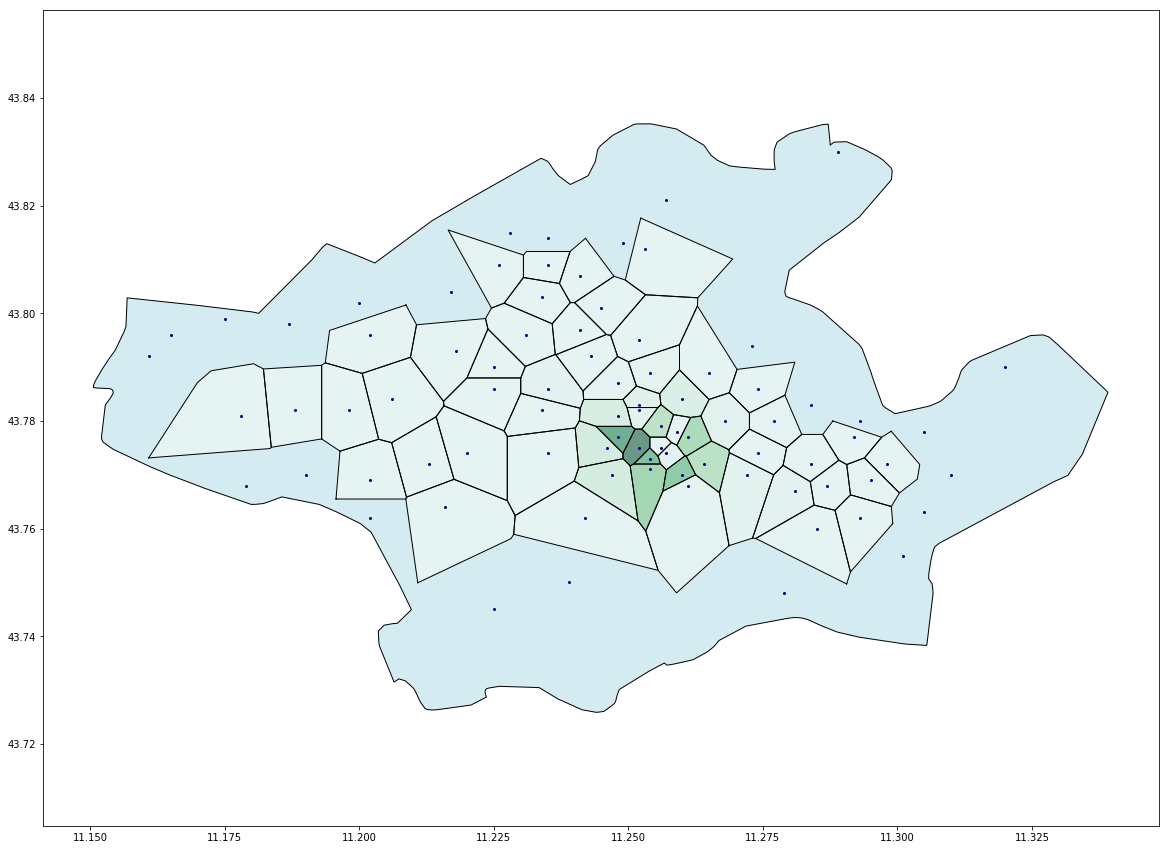

In [6]:
# Plot everything

plt.figure(figsize=(20, 15))
ax = plt.gca()

firenze_shp.plot(ax=ax, color='lightblue')
towers_in_firenze.plot(ax=ax, color='navy')
voronoi_geo_in_firenze.plot(ax=ax, column = "count_area", cmap="Greens")
#firenze_land_use_shp.plot(ax=ax, color='white', alpha=0.2, linewidth=0.5)

#voronoi_fig = voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_alpha=0.5)

plt.axes().set_aspect('equal', 'datalim')
plt.show()
